# Forecasting PEPCO Region's Real-Time Locational Marginal Price (i.e. Wholesale Electricity Price)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

from datetime import date, datetime
import holidays

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer

%load_ext autoreload
import helper_functions as hlp

# Importing Data
Importing previously prepared data.  
Converting time columns to proper datetime format.  
Creating a separate DataFrame with only the data from 2016 onward for use in modeling, but while retaining some 2015 data for use in the generation of lag variables.

In [2]:
# importing data and converting datetimes
lmp_data_tot = pd.read_csv('data/processed/price_data.csv')
lmp_data_tot['datetime_beginning_utc'] = pd.to_datetime(lmp_data_tot['datetime_beginning_utc'])
lmp_data_tot['datetime_beginning_ept'] = pd.to_datetime(lmp_data_tot['datetime_beginning_ept'])

# subsetting data to be from 2016 onwards
lmp_data = lmp_data_tot.loc[lmp_data_tot['datetime_beginning_ept']
                            >= pd.Timestamp(2016, 1, 1)
                           ].reset_index(drop=True).copy()

In [4]:
lmp_data.describe()

,total_lmp_rt,system_energy_price_rt,congestion_price_rt,marginal_loss_price_rt,total_lmp_da,system_energy_price_da,congestion_price_da,marginal_loss_price_da,pepco_mw,apsouth_flow_mw,apsouth_spread_mw,bcpep_flow_mw,bcpep_spread_mw,bed_bla_flow_mw,bed_bla_spread_mw,central_flow_mw,central_spread_mw,east_flow_mw,east_spread_mw,west_flow_mw,west_spread_mw,maintenance_outages_mw,forced_outages_mw,dewPoint,enthalpy,apparentTemperature,DD,CDD,HDD,uvIndex,peak_hour,humidity,humidity_ratio
count,34080.000000,34080.000000,34080.000000,34080.000000,34080.000000,34080.000000,34080.000000,34080.000000,34080.000000,34080.000000,34080.000000,34080.000000,34080.000000,34080.000000,34080.000000,34080.000000,34080.000000,34080.000000,34080.000000,34080.000000,34080.000000,34080.000000,34080.000000,34080.000000,34080.000000,34080.000000,34080.000000,34080.000000,34080.000000,34080.000000,34080.000000,34080.000000,34080.000000
mean,33.005022,29.847666,2.551362,0.606002,33.461132,29.950235,2.927821,0.583076,3036.968713,2101.850411,1351.380223,3563.257776,1992.296802,889.030546,535.052494,-895.392107,4051.289994,2807.611502,3325.026408,1251.969219,3463.453316,4856.125763,1941.737940,47.073609,23.276091,59.087889,0.706830,0.230248,0.476582,1.298166,0.468545,0.672790,0.008354
std,28.101713,21.930728,9.230076,0.840894,18.109079,14.868830,4.492250,0.619473,658.241332,887.530573,808.490954,1156.991403,1045.111547,367.110972,336.683261,1212.996531,1368.107521,1672.298546,1387.909413,1517.760199,1466.069890,2150.121215,1032.653181,19.206677,9.675226,19.911984,0.499428,0.357012,0.584330,2.120019,0.499017,0.189049,0.005128
min,-53.471480,-56.710000,-109.388085,-5.326984,4.636074,2.270000,-41.624613,-1.382850,1812.757000,-382.000000,0.000000,165.000000,0.000000,-602.000000,0.000000,-3596.000000,0.000000,-1314.000000,0.000000,-3056.000000,0.000000,-371.000000,265.000000,-14.280000,2.044572,-0.790000,0.000000,0.000000,0.000000,0.000000,0.000000,0.130000,0.000355
25%,22.703391,21.180000,0.000000,0.227115,23.991502,22.020000,0.510182,0.238615,2579.313500,1474.000000,741.000000,2702.000000,1242.000000,639.000000,300.000000,-1741.000000,3158.000000,1607.000000,2436.000000,160.000000,2454.000000,3294.000000,1221.000000,31.710000,14.724860,43.220000,0.310000,0.000000,0.000000,0.000000,0.000000,0.520000,0.003701
50%,27.215821,24.960000,0.276346,0.450049,29.645120,26.790000,1.780171,0.474784,2923.118000,2024.000000,1336.000000,3562.000000,1993.000000,857.000000,522.000000,-1100.000000,4058.000000,2616.000000,3393.000000,1057.000000,3499.000000,4773.000000,1715.000000,49.980000,23.035955,60.890000,0.590000,0.000000,0.170000,0.000000,0.000000,0.690000,0.007594
75%,34.001831,31.508125,2.986970,0.765767,37.995880,33.970000,3.870529,0.782814,3397.080750,2625.000000,1930.000000,4374.000000,2732.000000,1119.714286,745.000000,-318.000000,4930.000000,3812.000000,4294.000000,2142.000000,4464.000000,6225.000000,2494.000000,64.150000,31.802373,74.470000,1.040000,0.390000,0.910000,2.000000,1.000000,0.850000,0.012789
max,953.119790,690.027500,287.993853,27.531492,385.995223,294.830000,95.276622,11.172696,5813.240000,5677.000000,4582.000000,7200.000000,5601.000000,2000.000000,2102.000000,4843.000000,8274.000000,9837.000000,7826.000000,6326.000000,9035.000000,13155.000000,8538.000000,78.040000,46.034146,113.700000,2.740000,2.030000,2.740000,11.000000,1.000000,1.000000,0.020865


# Model with No Exogenous Regressors

In [5]:
# initializing model
m_lmp = hlp.init_prophet_model()

# generating the properly formatted dataframe
df_lmp = hlp.prophet_df(lmp_data, 'datetime_beginning_ept', 'total_lmp_rt')

# generating the prediction dataframe
pred_lmp = df_lmp.drop(columns=['y']).copy()

In [6]:
# fitting the model
m_lmp.fit(df_lmp);

In [7]:
# generating predictions
fcst_lmp = m_lmp.predict(pred_lmp)

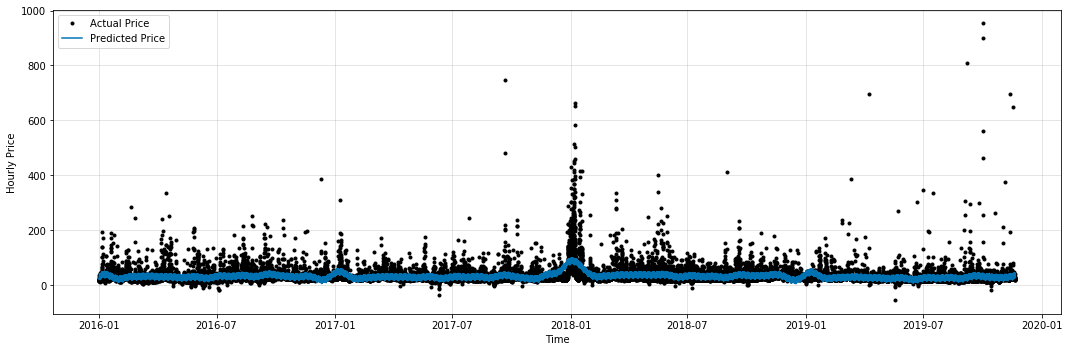

In [118]:
# plotting the actuals and predictions
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = m_lmp.plot(fcst_lmp, xlabel='Time', ylabel='Hourly Price',
                 uncertainty=False, ax=ax)
plt.gca().get_lines()[0].set_label("Actual Price")
plt.gca().get_lines()[1].set_label("Predicted Price")
plt.legend();

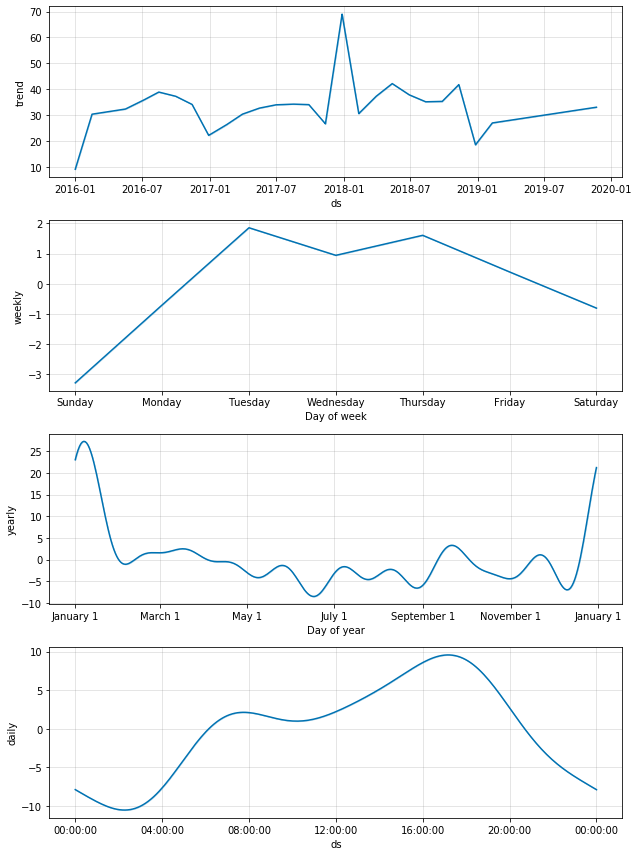

In [9]:
# plotting the decomposition
fig = m_lmp.plot_components(fcst_lmp)

This model has very poor performance and isn't picking up on the outliers or significant variance much at all.

In [10]:
# generating dataframe with predictions and actual values for comparison
compare_lmp = fcst_lmp.set_index('ds')[['yhat',
                                        'yhat_lower',
                                        'yhat_upper']
                                       ].join(df_lmp.set_index('ds'))
# printing the results
# Mean Squared Error (MSE), Mean Absolute Error (MAE), Mean Absolute Percent Error (MAPE)
hlp.print_metrics(compare_lmp['y'], compare_lmp['yhat'])

MSE:  657.59
MAE:  11.13
MAPE:  34.36 %


# Model with Exogenous Regressors
Additional regressors determined by apparent relevance from EDA are added to the model to better predict the residual error from the time series trend and seasonality regressions.

In [11]:
# creating list of selected regressors for use as baseline regressor model.
# regressors were selected based on EDA, but not rigorous quantitative feature selection.
lmp_base_reg = ['total_lmp_da', 'system_energy_price_da', 'congestion_price_da',
                'marginal_loss_price_da', 'pepco_mw', 'bcpep_flow_mw',
                'bcpep_spread_mw', 'maintenance_outages_mw', 'forced_outages_mw',
                'dewPoint', 'enthalpy', 'apparentTemperature', 'humidity',
                'DD', 'CDD', 'HDD', 'uvIndex', 'peak_hour']

# initializing model
m_lmp_base = hlp.init_prophet_model(lmp_base_reg, model=Prophet())

# generating the properly formatted dataframe
df_lmp_base = hlp.prophet_df(lmp_data, 'datetime_beginning_ept',
                             'total_lmp_rt', lmp_base_reg)

# generating the prediction dataframe
pred_lmp_base = df_lmp_base.drop(columns=['y']).copy()

In [12]:
# fitting the baseline model
m_lmp_base.fit(df_lmp_base);

In [13]:
# generating predictions
fcst_lmp_base = m_lmp_base.predict(pred_lmp_base)

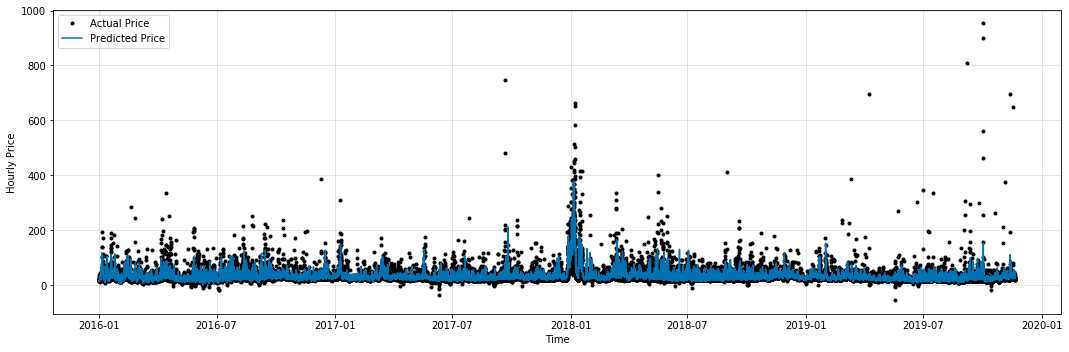

In [117]:
# plotting the actuals and predictions
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = m_lmp_base.plot(fcst_lmp_base, xlabel='Time', ylabel='Hourly Price',
                      uncertainty=False, ax=ax)
plt.gca().get_lines()[0].set_label("Actual Price")
plt.gca().get_lines()[1].set_label("Predicted Price")
plt.legend();

Major performance improvement, but more can be achieved

In [15]:
# generating dataframe with predictions and actual values for comparison
compare_lmp_base = fcst_lmp_base.set_index('ds')[['yhat',
                                                  'yhat_lower',
                                                  'yhat_upper']
                                                 ].join(df_lmp_base.set_index('ds'))

# printing the results
hlp.print_metrics(compare_lmp_base['y'], compare_lmp_base['yhat'])

MSE:  434.64
MAE:  7.65
MAPE:  21.06 %


# Model with Exogenous Regressors and Power Transformed Target
By using a power transform the target is made to be distributed normally, stabilizing variance and allowing large variations to be better predicted by the model, which is valuable given this data's high variance.

In [16]:
# Using the same list of regressors as the previous model
lmp_base_reg = ['total_lmp_da', 'system_energy_price_da', 'congestion_price_da',
                'marginal_loss_price_da', 'pepco_mw', 'bcpep_flow_mw',
                'bcpep_spread_mw', 'maintenance_outages_mw', 'forced_outages_mw',
                'dewPoint', 'enthalpy', 'apparentTemperature', 'humidity',
                'DD', 'CDD', 'HDD', 'uvIndex', 'peak_hour']

# initializing model
m_lmp_trans = hlp.init_prophet_model(lmp_base_reg, model=Prophet())

# generating the properly formatted dataframe
df_lmp_trans = hlp.prophet_df(lmp_data, 'datetime_beginning_ept',
                              'total_lmp_rt', lmp_base_reg)

# generating the prediction dataframe
pred_lmp_trans = df_lmp_trans.drop(columns=['y']).copy()

# performing the power transforms of the target
yj_lmp = PowerTransformer(method='yeo-johnson')
orig_lmp_y = df_lmp_trans['y'].copy()
pre_trans_lmp_y = np.array(orig_lmp_y).reshape(-1, 1)
transformed_y = yj_lmp.fit_transform(pre_trans_lmp_y)
df_lmp_trans['y'] = transformed_y

# since the target is the same for all total LMP models,
# this transformer, orig_lmp_y and transformed_y will be reused later in the notebook

In [17]:
# fitting the baseline model
m_lmp_trans.fit(df_lmp_trans);

In [18]:
# generating predictions
fcst_lmp_trans = m_lmp_trans.predict(pred_lmp_trans)

In [19]:
# inverse transforming the target to return it to interpretable units
for column in ['yhat', 'yhat_lower', 'yhat_upper']:
        fcst_lmp_trans[column] = yj_lmp.inverse_transform(np.array(fcst_lmp_trans[column]
                                                                  ).reshape(-1, 1))
m_lmp_trans.history['y'] = yj_lmp.inverse_transform(np.array(m_lmp_trans.history['y']
                                                            ).reshape(-1, 1))
df_lmp_trans['y'] = orig_lmp_y

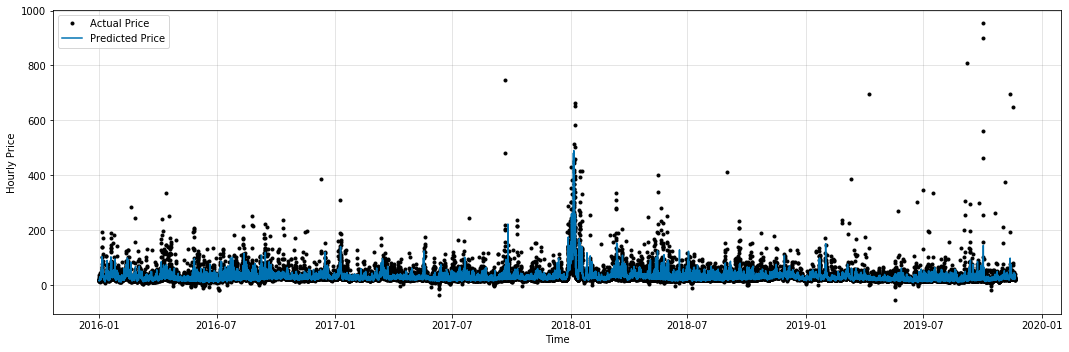

In [116]:
# plotting the actuals and predictions
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = m_lmp_trans.plot(fcst_lmp_trans, xlabel='Time', ylabel='Hourly Price',
                       uncertainty=False, ax=ax)
plt.gca().get_lines()[0].set_label("Actual Price")
plt.gca().get_lines()[1].set_label("Predicted Price")
plt.legend();

An incremental improvement that helps the model better pick up outliers

In [21]:
# generating dataframe with predictions and actual values for comparison
compare_lmp_trans = fcst_lmp_trans.set_index('ds')[['yhat',
                                                  'yhat_lower',
                                                  'yhat_upper']
                                                   ].join(df_lmp_trans.set_index('ds'))
# printing the results
hlp.print_metrics(compare_lmp_trans['y'], compare_lmp_trans['yhat'])

MSE:  442.45
MAE:  7.13
MAPE:  18.9 %


# Feature Engineering
Engineering a series of polynomial and interaction variables based on understanding and inspection of important features and their relationships to each other.  
  
Also, lag variables (the value of other features at a period in the past relative to the prediction) were introduced to take advantage of the short time horizon of the forecasts and high correlation between a given hour's price and those recently preceding it. The lag variables must be as far back as you plan to predict forward to allow them to be present when making predictions in real time. For this reason, a 1-, and 2-hour ahead model is generated later in this notebook to allow the 1-hour model to look 1 hour closer into the past than the 2-hour model can. The data includes numerous short-term trends (over a few hours or days) that are not reflected in the overall trends and seasonalities learned by the model, which is at its core and additive regression model that fits decomposed components of the target time-series, so introducing lag variables allows the model to pick up on short-term trends that even the changepoint and other hyperparameters cannot pick up on. 
  
This section does not represent all attempted feature engineering, just what ultimately made it into the final model, which happened to be polynomials and interactions of the price components.

In [22]:
# generating polynomial features
cols_for_poly = ['system_energy_price_da',
                 'congestion_price_da',
                 'marginal_loss_price_da']

polyd_col_names = ['sys_energy_da_2',
                   'congestion_da_2',
                   'marginal_da_2']

lmp_data = hlp.create_poly_feat(lmp_data,
                                cols_for_poly, polyd_col_names)
lmp_data_tot = hlp.create_poly_feat(lmp_data_tot,
                                    cols_for_poly, polyd_col_names)

In [23]:
# generating interaction features
cols_for_interact = [('system_energy_price_da', 'congestion_price_da'),
                     ('system_energy_price_da', 'marginal_loss_price_da'),
                     ('congestion_price_da', 'marginal_loss_price_da')]

interacted_col_names = ['sys_energy_congest_da',
                        'sys_energy_marginal_da',
                        'marginal_congest_da']

lmp_data = hlp.create_interact_feat(lmp_data,
                                    cols_for_interact, interacted_col_names)
lmp_data_tot = hlp.create_interact_feat(lmp_data_tot,
                                        cols_for_interact, interacted_col_names)

In [24]:
# Generating lag variables for the last 4 hours for each hour in a given day
# as well as the previous day's value at the same hour and 3 prior hours.
cols_to_lag = ['system_energy_price_rt', 'congestion_price_rt', 'marginal_loss_price_rt',
               'system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da',
               'sys_energy_congest_da', 'sys_energy_marginal_da', 'marginal_congest_da',
               'sys_energy_da_2', 'congestion_da_2', 'marginal_da_2']

lmp_data_lag = lmp_data_tot[['datetime_beginning_utc']].copy()

for i in [1, 2, 3, 4, 24, 25, 26, 27]:
    for col in cols_to_lag:
        lmp_data_lag[col+'_lag_{}'.format(i)] = lmp_data_tot[col].shift(i)

lmp_data = lmp_data.merge(lmp_data_lag,
                          how='left',
                          left_on='datetime_beginning_utc',
                          right_on='datetime_beginning_utc')

In [25]:
lag_cols_for_poly = ['system_energy_price_rt_lag_1', 'congestion_price_rt_lag_1', 'marginal_loss_price_rt_lag_1',
                     'system_energy_price_rt_lag_2', 'congestion_price_rt_lag_2', 'marginal_loss_price_rt_lag_2',
                     'system_energy_price_rt_lag_24', 'congestion_price_rt_lag_24', 'marginal_loss_price_rt_lag_24',
                     'system_energy_price_rt_lag_25', 'congestion_price_rt_lag_25', 'marginal_loss_price_rt_lag_25',
                     'system_energy_price_da_lag_1', 'congestion_price_da_lag_1', 'marginal_loss_price_da_lag_1',
                     'system_energy_price_da_lag_2', 'congestion_price_da_lag_2', 'marginal_loss_price_da_lag_2',
                     'system_energy_price_da_lag_24', 'congestion_price_da_lag_24', 'marginal_loss_price_da_lag_24',
                     'system_energy_price_da_lag_25', 'congestion_price_da_lag_25', 'marginal_loss_price_da_lag_25']

lag_polyd_col_names = ['sys_energy_da_2_lag_1', 'congestion_da_2_lag_1', 'marginal_da_2_lag_1',
                       'sys_energy_da_2_lag_2', 'congestion_da_2_lag_2', 'marginal_da_2_lag_2',
                       'sys_energy_da_2_lag_24', 'congestion_da_2_lag_24', 'marginal_da_2_lag_24',
                       'sys_energy_da_2_lag_25', 'congestion_da_2_lag_25', 'marginal_da_2_lag_25',
                       'sys_energy_rt_2_lag_1', 'congestion_rt_2_lag_1', 'marginal_rt_2_lag_1',
                       'sys_energy_rt_2_lag_2', 'congestion_rt_2_lag_2', 'marginal_rt_2_lag_2',
                       'sys_energy_rt_2_lag_24', 'congestion_rt_2_lag_24', 'marginal_rt_2_lag_24',
                       'sys_energy_rt_2_lag_25', 'congestion_rt_2_lag_25', 'marginal_rt_2_lag_25']

lmp_data = hlp.create_poly_feat(lmp_data,
                                lag_cols_for_poly, lag_polyd_col_names)

In [26]:
lag_cols_for_interact = [('system_energy_price_da_lag_1', 'congestion_price_da_lag_1'),
                         ('system_energy_price_da_lag_1', 'marginal_loss_price_da_lag_1'),
                         ('congestion_price_da_lag_1', 'marginal_loss_price_da_lag_1'),
                         ('system_energy_price_da_lag_2', 'congestion_price_da_lag_2'),
                         ('system_energy_price_da_lag_2', 'marginal_loss_price_da_lag_2'),
                         ('congestion_price_da_lag_2', 'marginal_loss_price_da_lag_2'),
                         ('system_energy_price_da_lag_24', 'congestion_price_da_lag_24'),
                         ('system_energy_price_da_lag_24', 'marginal_loss_price_da_lag_24'),
                         ('congestion_price_da_lag_24', 'marginal_loss_price_da_lag_24'),
                         ('system_energy_price_da_lag_25', 'congestion_price_da_lag_25'),
                         ('system_energy_price_da_lag_25', 'marginal_loss_price_da_lag_25'),
                         ('congestion_price_da_lag_25', 'marginal_loss_price_da_lag_25'),
                         ('system_energy_price_rt_lag_1', 'congestion_price_rt_lag_1'),
                         ('system_energy_price_rt_lag_1', 'marginal_loss_price_rt_lag_1'),
                         ('congestion_price_rt_lag_1', 'marginal_loss_price_rt_lag_1'),
                         ('system_energy_price_rt_lag_2', 'congestion_price_rt_lag_2'),
                         ('system_energy_price_rt_lag_2', 'marginal_loss_price_rt_lag_2'),
                         ('congestion_price_rt_lag_2', 'marginal_loss_price_rt_lag_2'),
                         ('system_energy_price_rt_lag_24', 'congestion_price_rt_lag_24'),
                         ('system_energy_price_rt_lag_24', 'marginal_loss_price_rt_lag_24'),
                         ('congestion_price_rt_lag_24', 'marginal_loss_price_rt_lag_24'),
                         ('system_energy_price_rt_lag_25', 'congestion_price_rt_lag_25'),
                         ('system_energy_price_rt_lag_25', 'marginal_loss_price_rt_lag_25'),
                         ('congestion_price_rt_lag_25', 'marginal_loss_price_rt_lag_25')]

lag_interacted_col_names = ['sys_energy_congest_da_lag_1', 'sys_energy_marginal_da_lag_1', 'marginal_congest_da_lag_1',
                            'sys_energy_congest_da_lag_2', 'sys_energy_marginal_da_lag_2', 'marginal_congest_da_lag_2',
                            'sys_energy_congest_da_lag_24', 'sys_energy_marginal_da_lag_24', 'marginal_congest_da_lag_24',
                            'sys_energy_congest_da_lag_25', 'sys_energy_marginal_da_lag_25', 'marginal_congest_da_lag_25',
                            'sys_energy_congest_rt_lag_1', 'sys_energy_marginal_rt_lag_1', 'marginal_congest_rt_lag_1',
                            'sys_energy_congest_rt_lag_2', 'sys_energy_marginal_rt_lag_2', 'marginal_congest_rt_lag_2',
                            'sys_energy_congest_rt_lag_24', 'sys_energy_marginal_rt_lag_24', 'marginal_congest_rt_lag_24',
                            'sys_energy_congest_rt_lag_25', 'sys_energy_marginal_rt_lag_25', 'marginal_congest_rt_lag_25']

lmp_data = hlp.create_interact_feat(lmp_data,
                                    lag_cols_for_interact, lag_interacted_col_names)

# Model with Selected Features, Scaled Exogenous Regressors, and Power Transformed Target
Forward selection was utilized to iterate through various and increasing combinations of feature and improve the model performance. This process also informed which features were ultimately engineered. Hyperparameter tuning was conducted, but modifications to the hyperparameters did not yield meaningful improvements over the default values.

In [89]:
# creating final list of selected features
lmp_final_reg = ['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da',
                 'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw',
                 'sys_energy_congest_da', 'sys_energy_marginal_da', 'marginal_congest_da',
                 'sys_energy_da_2', 'congestion_da_2', 'marginal_da_2', 'HDD', 'CDD', 'humidity',
                 'system_energy_price_rt_lag_1', 'congestion_price_rt_lag_1', 'marginal_loss_price_rt_lag_1',
                 'system_energy_price_rt_lag_2', 'congestion_price_rt_lag_2', 'marginal_loss_price_rt_lag_2',
                 'system_energy_price_rt_lag_3', 'congestion_price_rt_lag_3', 'marginal_loss_price_rt_lag_3',
                 'system_energy_price_rt_lag_4', 'congestion_price_rt_lag_4', 'marginal_loss_price_rt_lag_4',
                 'system_energy_price_rt_lag_24', 'congestion_price_rt_lag_24', 'marginal_loss_price_rt_lag_24',
                 'system_energy_price_rt_lag_25', 'congestion_price_rt_lag_25', 'marginal_loss_price_rt_lag_25',
                 'system_energy_price_rt_lag_26', 'congestion_price_rt_lag_26', 'marginal_loss_price_rt_lag_26',
                 'system_energy_price_rt_lag_27', 'congestion_price_rt_lag_27', 'marginal_loss_price_rt_lag_27',
                 'sys_energy_congest_da_lag_1', 'sys_energy_marginal_da_lag_1', 'marginal_congest_da_lag_1',
                 'sys_energy_da_2_lag_1', 'congestion_da_2_lag_1', 'marginal_da_2_lag_1',
                 'sys_energy_congest_da_lag_2', 'sys_energy_marginal_da_lag_2', 'marginal_congest_da_lag_2',
                 'sys_energy_da_2_lag_2', 'congestion_da_2_lag_2', 'marginal_da_2_lag_2',
                 'sys_energy_congest_da_lag_24', 'sys_energy_marginal_da_lag_24', 'marginal_congest_da_lag_24',
                 'sys_energy_da_2_lag_24', 'congestion_da_2_lag_24', 'marginal_da_2_lag_24',
                 'sys_energy_congest_da_lag_25', 'sys_energy_marginal_da_lag_25', 'marginal_congest_da_lag_25',
                 'sys_energy_da_2_lag_25', 'congestion_da_2_lag_25', 'marginal_da_2_lag_25',
                 'sys_energy_congest_rt_lag_1', 'sys_energy_marginal_rt_lag_1', 'marginal_congest_rt_lag_1',
                 'sys_energy_rt_2_lag_1', 'congestion_rt_2_lag_1', 'marginal_rt_2_lag_1',
                 'sys_energy_congest_rt_lag_2', 'sys_energy_marginal_rt_lag_2', 'marginal_congest_rt_lag_2',
                 'sys_energy_rt_2_lag_2', 'congestion_rt_2_lag_2', 'marginal_rt_2_lag_2',
                 'sys_energy_congest_rt_lag_24', 'sys_energy_marginal_rt_lag_24', 'marginal_congest_rt_lag_24',
                 'sys_energy_rt_2_lag_24', 'congestion_rt_2_lag_24', 'marginal_rt_2_lag_24',
                 'sys_energy_congest_rt_lag_25', 'sys_energy_marginal_rt_lag_25', 'marginal_congest_rt_lag_25',
                 'sys_energy_rt_2_lag_25', 'congestion_rt_2_lag_25', 'marginal_rt_2_lag_25',
                 'system_energy_price_da_lag_1', 'congestion_price_da_lag_1', 'marginal_loss_price_da_lag_1',
                 'system_energy_price_da_lag_2', 'congestion_price_da_lag_2', 'marginal_loss_price_da_lag_2',
                 'system_energy_price_da_lag_24', 'congestion_price_da_lag_24', 'marginal_loss_price_da_lag_24',
                 'system_energy_price_da_lag_25', 'congestion_price_da_lag_25', 'marginal_loss_price_da_lag_25']

# initializing model
m_lmp_final = hlp.init_prophet_model(lmp_final_reg, model=Prophet())
# seasonality_prior_scale=0.2

# generating the properly formatted dataframe
df_lmp_final = hlp.prophet_df(lmp_data, 'datetime_beginning_ept',
                              'total_lmp_rt', lmp_final_reg)

# scaling the regressors
std_scaler_lmp_final = StandardScaler()
std_reg_lmp_final = std_scaler_lmp_final.fit_transform(df_lmp_final[lmp_final_reg])
df_lmp_final[lmp_final_reg] = std_reg_lmp_final

# performing the power transforms of the target
df_lmp_final['y'] = transformed_y

# generating the prediction dataframe
pred_lmp_final = df_lmp_final.drop(columns=['y']).copy()

In [90]:
# fitting the model
m_lmp_final.fit(df_lmp_final);

In [91]:
# generating predictions
fcst_lmp_final = m_lmp_final.predict(pred_lmp_final)

In [92]:
# inverse transforming the target to return it to interpretable units
for column in ['yhat', 'yhat_lower', 'yhat_upper']:
        fcst_lmp_final[column] = yj_lmp.inverse_transform(np.array(fcst_lmp_final[column]
                                                                  ).reshape(-1, 1))
m_lmp_final.history['y'] = yj_lmp.inverse_transform(np.array(m_lmp_final.history['y']
                                                            ).reshape(-1, 1))
df_lmp_final['y'] = orig_lmp_y

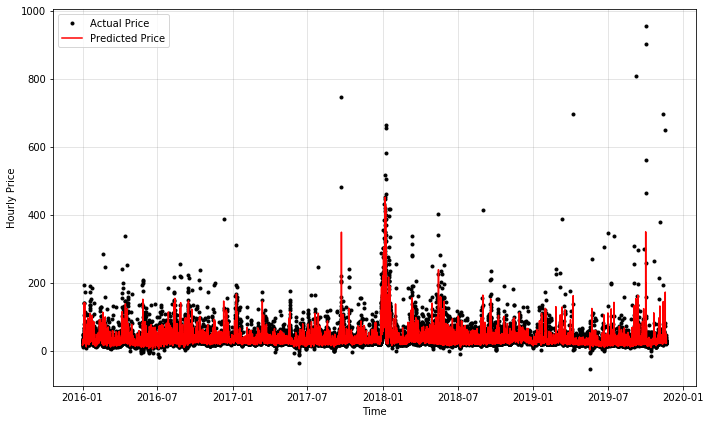

In [93]:
# plotting the actuals and predictions
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(10)
fig = m_lmp_final.plot(fcst_lmp_final, xlabel='Time', ylabel='Hourly Price',
                       uncertainty=False, ax=ax)
plt.gca().get_lines()[1].set_color("red")
plt.gca().get_lines()[0].set_label("Actual Price")
plt.gca().get_lines()[1].set_label("Predicted Price")
plt.legend();
# plt.savefig('img/Predictions.png');

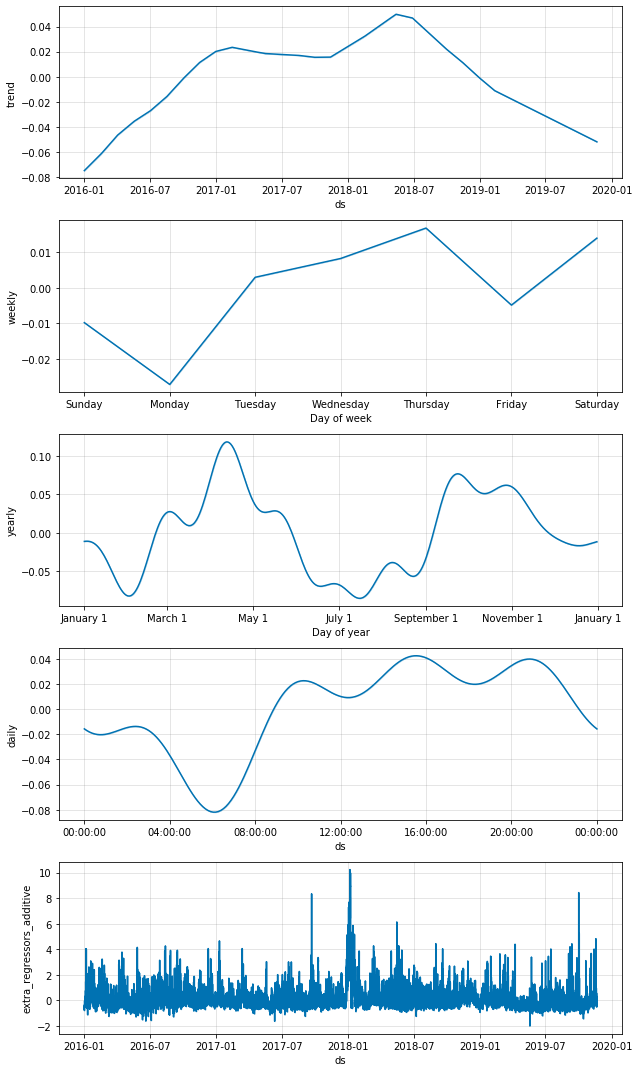

In [94]:
# plotting the decomposition
fig = m_lmp_final.plot_components(fcst_lmp_final)

In [95]:
# inverse scaling of regressors
df_lmp_final[lmp_final_reg] = std_scaler_lmp_final.inverse_transform(df_lmp_final[lmp_final_reg])

# generating dataframe with predictions and actual values for comparison
compare_lmp_final = fcst_lmp_final.set_index('ds')[['yhat',
                                                    'yhat_lower',
                                                    'yhat_upper']
                                                   ].join(df_lmp_final.set_index('ds'))
# printing the model results
hlp.print_metrics(compare_lmp_final['y'], compare_lmp_final['yhat'])

MSE:  344.16
MAE:  6.1
MAPE:  15.74 %


To determine whether the model is better at predicting the prices than simply assuming they will match the publicly available day-ahead prices, the error statistics between the day-ahead (i.e. baseline prediction) and the real-time LMPs are generated for comparison with the model results. The model is about 5% more accurate than the day-ahead LMPs for 1-hour ahead predictions.

In [96]:
# generating dataframe with day-ahead and actual real-time values for comparison
compare_lmp_final['da_yhat'] = (compare_lmp_final['system_energy_price_da']
                                + compare_lmp_final['congestion_price_da']
                                + compare_lmp_final['marginal_loss_price_da'])

# printing the error between day-ahead and real-time prices
hlp.print_metrics(compare_lmp_final['y'], compare_lmp_final['da_yhat'])

MSE:  443.23
MAE:  7.57
MAPE:  20.51 %


# 2-hour Ahead Model
Essentially the same model as the 1-hour ahead model, but the 1-hour lag variables are removed as they aren't be available 2-hours ahead.

In [97]:
# selected regressors with 1-hou lags removed
lmp_final_reg_2 = ['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da',
                   'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw',
                   'sys_energy_congest_da', 'sys_energy_marginal_da', 'marginal_congest_da',
                   'sys_energy_da_2', 'congestion_da_2', 'marginal_da_2', 'HDD', 'CDD', 'humidity',
                   'system_energy_price_rt_lag_2', 'congestion_price_rt_lag_2', 'marginal_loss_price_rt_lag_2',
                   'system_energy_price_rt_lag_3', 'congestion_price_rt_lag_3', 'marginal_loss_price_rt_lag_3',
                   'system_energy_price_rt_lag_4', 'congestion_price_rt_lag_4', 'marginal_loss_price_rt_lag_4',
                   'system_energy_price_rt_lag_24', 'congestion_price_rt_lag_24', 'marginal_loss_price_rt_lag_24',
                   'system_energy_price_rt_lag_25', 'congestion_price_rt_lag_25', 'marginal_loss_price_rt_lag_25',
                   'system_energy_price_rt_lag_26', 'congestion_price_rt_lag_26', 'marginal_loss_price_rt_lag_26',
                   'system_energy_price_rt_lag_27', 'congestion_price_rt_lag_27', 'marginal_loss_price_rt_lag_27',
                   'sys_energy_congest_da_lag_1', 'sys_energy_marginal_da_lag_1', 'marginal_congest_da_lag_1',
                   'sys_energy_da_2_lag_1', 'congestion_da_2_lag_1', 'marginal_da_2_lag_1',
                   'sys_energy_congest_da_lag_2', 'sys_energy_marginal_da_lag_2', 'marginal_congest_da_lag_2',
                   'sys_energy_da_2_lag_2', 'congestion_da_2_lag_2', 'marginal_da_2_lag_2',
                   'sys_energy_congest_da_lag_24', 'sys_energy_marginal_da_lag_24', 'marginal_congest_da_lag_24',
                   'sys_energy_da_2_lag_24', 'congestion_da_2_lag_24', 'marginal_da_2_lag_24',
                   'sys_energy_congest_da_lag_25', 'sys_energy_marginal_da_lag_25', 'marginal_congest_da_lag_25',
                   'sys_energy_da_2_lag_25', 'congestion_da_2_lag_25', 'marginal_da_2_lag_25',
                   'sys_energy_congest_rt_lag_2', 'sys_energy_marginal_rt_lag_2', 'marginal_congest_rt_lag_2',
                   'sys_energy_rt_2_lag_2', 'congestion_rt_2_lag_2', 'marginal_rt_2_lag_2',
                   'sys_energy_congest_rt_lag_24', 'sys_energy_marginal_rt_lag_24', 'marginal_congest_rt_lag_24',
                   'sys_energy_rt_2_lag_24', 'congestion_rt_2_lag_24', 'marginal_rt_2_lag_24',
                   'sys_energy_congest_rt_lag_25', 'sys_energy_marginal_rt_lag_25', 'marginal_congest_rt_lag_25',
                   'sys_energy_rt_2_lag_25', 'congestion_rt_2_lag_25', 'marginal_rt_2_lag_25',
                   'system_energy_price_da_lag_1', 'congestion_price_da_lag_1', 'marginal_loss_price_da_lag_1',
                   'system_energy_price_da_lag_2', 'congestion_price_da_lag_2', 'marginal_loss_price_da_lag_2',
                   'system_energy_price_da_lag_24', 'congestion_price_da_lag_24', 'marginal_loss_price_da_lag_24',
                   'system_energy_price_da_lag_25', 'congestion_price_da_lag_25', 'marginal_loss_price_da_lag_25']

# initializing the model
m_lmp_final_2 = hlp.init_prophet_model(lmp_final_reg_2, model=Prophet())
# seasonality_prior_scale=0.2

# generating the properly formatted dataframe
df_lmp_final_2 = hlp.prophet_df(lmp_data, 'datetime_beginning_ept',
                                'total_lmp_rt', lmp_final_reg_2)

# scaling the regressors
std_scaler_lmp_final_2 = StandardScaler()
std_reg_lmp_final_2 = std_scaler_lmp_final_2.fit_transform(df_lmp_final_2[lmp_final_reg_2])
df_lmp_final_2[lmp_final_reg_2] = std_reg_lmp_final_2

# performing the power transforms of the target
df_lmp_final_2['y'] = transformed_y

# generating the prediction dataframe
pred_lmp_final_2 = df_lmp_final_2.drop(columns=['y']).copy()

In [98]:
# fitting the model
m_lmp_final_2.fit(df_lmp_final_2);

In [99]:
# generating predictions
fcst_lmp_final_2 = m_lmp_final_2.predict(pred_lmp_final_2)

In [100]:
# inverse transforming the target to return it to interpretable units
for column in ['yhat', 'yhat_lower', 'yhat_upper']:
        fcst_lmp_final_2[column] = yj_lmp.inverse_transform(np.array(fcst_lmp_final_2[column]
                                                                    ).reshape(-1, 1))
m_lmp_final_2.history['y'] = yj_lmp.inverse_transform(np.array(m_lmp_final_2.history['y']
                                                              ).reshape(-1, 1))
df_lmp_final_2['y'] = orig_lmp_y

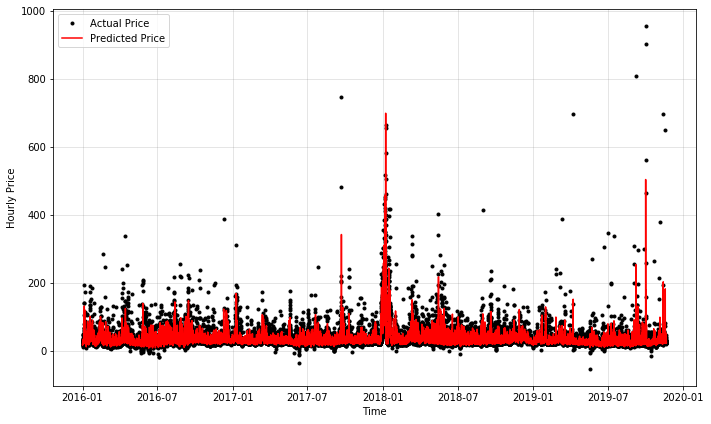

In [101]:
# plotting the actuals and predictions
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(10)
fig = m_lmp_final_2.plot(fcst_lmp_final_2, xlabel='Time', ylabel='Hourly Price',
                         uncertainty=False, ax=ax)
plt.gca().get_lines()[1].set_color("red")
plt.gca().get_lines()[0].set_label("Actual Price")
plt.gca().get_lines()[1].set_label("Predicted Price")
plt.legend();

In [102]:
# generating dataframe with predictions and actual values for comparison
compare_lmp_final_2 = fcst_lmp_final_2.set_index('ds')[['yhat',
                                                        'yhat_lower',
                                                        'yhat_upper']
                                                       ].join(df_lmp_final_2.set_index('ds'))
# printing the model results
hlp.print_metrics(compare_lmp_final_2['y'], compare_lmp_final_2['yhat'])

MSE:  365.42
MAE:  6.51
MAPE:  17.02 %


# Cross Validating the Final 1-hour Ahead Prediction Model
The initial model is fit on the 2016 and 2017 data. All prediction horizons are the subsequent two hours, and then the model incorporates an additional 25 hours into the time period that is fit followed by another two hour prediction horizon. This process repeats until the end of the time period for which there is data. The 25 hour period was chosen to keep the processing time somewhat contained, but also allowing for each hour of a given month to be predicted even if they are performed for separate days.

In [112]:
# performing the cross validation
lmp_trans_cv = cross_validation(m_lmp_final, initial='26285 hours',
                                period='25 hours', horizon = '2 hours')

INFO:fbprophet:Making 312 forecasts with cutoffs between 2018-12-31 22:00:00 and 2019-11-20 21:00:00


In [113]:
# evaluating the tabular results 
# shows good performance in line with the previously observed model results
lmp_trans_p = performance_metrics(lmp_trans_cv)
lmp_trans_p.head()

,horizon,mse,rmse,mae,mape,coverage
0,01:00:00,242.630354,15.576596,5.285322,0.147604,0.961538
1,02:00:00,247.131017,15.720401,5.429496,0.142925,0.955128


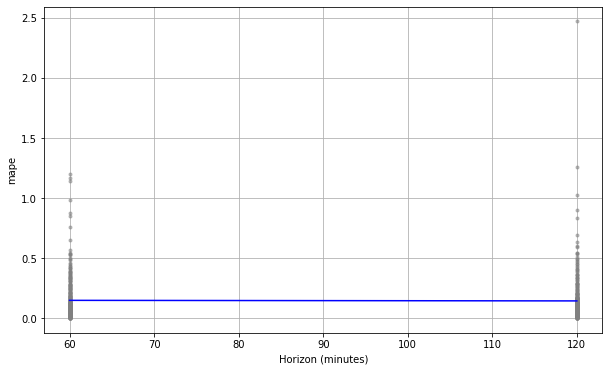

In [114]:
# plotting the results
fig = plot_cross_validation_metric(lmp_trans_cv, metric='mape')

# Modeling Individual Price Components
Inspected whether independently modeling the three components (System Energy, Congestion, and Marginal) of Locational Marginal Price would yield more accurate results than modeling the total price. Results showed slightly worse performance

In [103]:
# creating list of all possible regressors for use as baseline model
eng_sel_reg = ['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da',
               'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw',
               'sys_energy_da_2', 'HDD', 'CDD', 'humidity',
               'system_energy_price_rt_lag_1', 'system_energy_price_rt_lag_2',
               'system_energy_price_rt_lag_3', 'system_energy_price_rt_lag_4',
               'system_energy_price_rt_lag_24', 'system_energy_price_rt_lag_25',
               'system_energy_price_rt_lag_26', 'system_energy_price_rt_lag_27',
               'sys_energy_da_2_lag_1', 'sys_energy_da_2_lag_2',
               'sys_energy_da_2_lag_24', 'sys_energy_da_2_lag_25',
               'sys_energy_rt_2_lag_1', 'sys_energy_rt_2_lag_2',
               'sys_energy_rt_2_lag_24', 'sys_energy_rt_2_lag_25',
               'system_energy_price_da_lag_1', 'system_energy_price_da_lag_2',
               'system_energy_price_da_lag_24', 'system_energy_price_da_lag_25']

cong_sel_reg = ['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da',
                'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw',
                'congestion_da_2','HDD', 'CDD', 'humidity',
                'congestion_price_rt_lag_1', 'congestion_price_rt_lag_2',
                'congestion_price_rt_lag_3', 'congestion_price_rt_lag_4',
                'congestion_price_rt_lag_24', 'congestion_price_rt_lag_25',
                'congestion_price_rt_lag_26', 'congestion_price_rt_lag_27',
                'congestion_da_2_lag_1', 'congestion_da_2_lag_2',
                'congestion_da_2_lag_24', 'congestion_da_2_lag_25',
                'congestion_rt_2_lag_1', 'congestion_rt_2_lag_2',
                'congestion_rt_2_lag_24', 'congestion_rt_2_lag_25',
                'congestion_price_da_lag_1', 'congestion_price_da_lag_2',
                'congestion_price_da_lag_24', 'congestion_price_da_lag_25']

marg_sel_reg = ['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da',
                'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw',
                'marginal_da_2', 'HDD', 'CDD', 'humidity',
                'marginal_loss_price_rt_lag_1', 'marginal_loss_price_rt_lag_2',
                'marginal_loss_price_rt_lag_3', 'marginal_loss_price_rt_lag_4',
                'marginal_loss_price_rt_lag_24', 'marginal_loss_price_rt_lag_25',
                'marginal_loss_price_rt_lag_26', 'marginal_loss_price_rt_lag_27',
                'marginal_da_2_lag_1', 'marginal_da_2_lag_2',
                'marginal_da_2_lag_24', 'marginal_da_2_lag_25',
                'marginal_rt_2_lag_1', 'marginal_rt_2_lag_2',
                'marginal_rt_2_lag_24', 'marginal_rt_2_lag_25',
                'marginal_loss_price_da_lag_1', 'marginal_loss_price_da_lag_2',
                'marginal_loss_price_da_lag_24', 'marginal_loss_price_da_lag_25']

# initializing the models
m_lmp_eng = hlp.init_prophet_model(eng_sel_reg, model=Prophet())
m_lmp_cong = hlp.init_prophet_model(cong_sel_reg, model=Prophet())
m_lmp_marg = hlp.init_prophet_model(marg_sel_reg, model=Prophet())

# generating the properly formatted dataframes
df_lmp_eng = hlp.prophet_df(lmp_data, 'datetime_beginning_ept',
                            'total_lmp_rt', eng_sel_reg)
df_lmp_cong = hlp.prophet_df(lmp_data, 'datetime_beginning_ept',
                             'total_lmp_rt', cong_sel_reg)
df_lmp_marg = hlp.prophet_df(lmp_data, 'datetime_beginning_ept',
                             'total_lmp_rt', marg_sel_reg)

# scaling the regressors
std_scaler_lmp_eng = StandardScaler()
std_reg_lmp_eng = std_scaler_lmp_eng.fit_transform(df_lmp_eng[eng_sel_reg])
df_lmp_eng[eng_sel_reg] = std_reg_lmp_eng

std_scaler_lmp_cong = StandardScaler()
std_reg_lmp_cong = std_scaler_lmp_cong.fit_transform(df_lmp_cong[cong_sel_reg])
df_lmp_cong[cong_sel_reg] = std_reg_lmp_cong

std_scaler_lmp_marg = StandardScaler()
std_reg_lmp_marg = std_scaler_lmp_marg.fit_transform(df_lmp_marg[marg_sel_reg])
df_lmp_marg[marg_sel_reg] = std_reg_lmp_marg

# performing the power transforms of the target
yj_lmp_eng = PowerTransformer(method='yeo-johnson')
yj_lmp_cong = PowerTransformer(method='yeo-johnson')
yj_lmp_marg = PowerTransformer(method='yeo-johnson')

orig_lmp_y_eng = df_lmp_eng['y'].copy()
pre_trans_lmp_y_eng = np.array(orig_lmp_y_eng).reshape(-1, 1)
transformed_y_eng = yj_lmp_eng.fit_transform(pre_trans_lmp_y_eng)
df_lmp_eng['y'] = transformed_y_eng

orig_lmp_y_cong = df_lmp_cong['y'].copy()
pre_trans_lmp_y_cong = np.array(orig_lmp_y_cong).reshape(-1, 1)
transformed_y_cong = yj_lmp_cong.fit_transform(pre_trans_lmp_y_cong)
df_lmp_cong['y'] = transformed_y_cong

orig_lmp_y_marg = df_lmp_marg['y'].copy()
pre_trans_lmp_y_marg = np.array(orig_lmp_y_marg).reshape(-1, 1)
transformed_y_marg = yj_lmp_marg.fit_transform(pre_trans_lmp_y_marg)
df_lmp_marg['y'] = transformed_y_marg

# generating the prediction dataframes
pred_lmp_eng = df_lmp_eng.drop(columns=['y']).copy()
pred_lmp_cong = df_lmp_cong.drop(columns=['y']).copy()
pred_lmp_marg = df_lmp_marg.drop(columns=['y']).copy()

In [104]:
# fitting the models
m_lmp_eng.fit(df_lmp_eng)
m_lmp_cong.fit(df_lmp_cong)
m_lmp_marg.fit(df_lmp_marg);

In [105]:
# generating predictions
fcst_lmp_eng = m_lmp_eng.predict(pred_lmp_eng)
fcst_lmp_cong = m_lmp_cong.predict(pred_lmp_cong)
fcst_lmp_marg = m_lmp_marg.predict(pred_lmp_marg)

In [106]:
# inverse transforming the target to return it to interpretable units
for column in ['yhat', 'yhat_lower', 'yhat_upper']:
        fcst_lmp_eng[column] = yj_lmp_eng.inverse_transform(np.array(fcst_lmp_eng[column]
                                                                    ).reshape(-1, 1))
m_lmp_eng.history['y'] = yj_lmp_eng.inverse_transform(np.array(m_lmp_eng.history['y']
                                                              ).reshape(-1, 1))
df_lmp_eng['y'] = orig_lmp_y_eng

for column in ['yhat', 'yhat_lower', 'yhat_upper']:
        fcst_lmp_cong[column] = yj_lmp_cong.inverse_transform(np.array(fcst_lmp_cong[column]
                                                                      ).reshape(-1, 1))
m_lmp_cong.history['y'] = yj_lmp_cong.inverse_transform(np.array(m_lmp_cong.history['y']
                                                                ).reshape(-1, 1))
df_lmp_cong['y'] = orig_lmp_y_cong

for column in ['yhat', 'yhat_lower', 'yhat_upper']:
        fcst_lmp_marg[column] = yj_lmp_marg.inverse_transform(np.array(fcst_lmp_marg[column]
                                                                      ).reshape(-1, 1))
m_lmp_marg.history['y'] = yj_lmp_marg.inverse_transform(np.array(m_lmp_marg.history['y']
                                                                ).reshape(-1, 1))
df_lmp_marg['y'] = orig_lmp_y_marg

# inverse scaling the regressors
df_lmp_eng[eng_sel_reg] = std_scaler_lmp_eng.inverse_transform(df_lmp_eng[eng_sel_reg])

df_lmp_cong[cong_sel_reg] = std_scaler_lmp_cong.inverse_transform(df_lmp_cong[cong_sel_reg])

df_lmp_marg[marg_sel_reg] = std_scaler_lmp_marg.inverse_transform(df_lmp_marg[marg_sel_reg])

# generating dataframes with predictions and actual values for comparison
compare_lmp_eng = fcst_lmp_eng.set_index('ds')[['yhat',
                                                'yhat_lower',
                                                'yhat_upper']
                                               ].join(df_lmp_eng.set_index('ds'))

compare_lmp_cong = fcst_lmp_cong.set_index('ds')[['yhat',
                                                  'yhat_lower',
                                                  'yhat_upper']
                                                 ].join(df_lmp_cong.set_index('ds'))

compare_lmp_marg = fcst_lmp_marg.set_index('ds')[['yhat',
                                                  'yhat_lower',
                                                  'yhat_upper']
                                                 ].join(df_lmp_marg.set_index('ds'))

# combining the prices into the total LMP for comparison purposes
compare_lmps = pd.DataFrame()
compare_lmps['y'] = compare_lmp_eng['y'] + compare_lmp_cong['y'] + compare_lmp_marg['y']
compare_lmps['yhat'] = compare_lmp_eng['yhat'] + compare_lmp_cong['yhat'] + compare_lmp_marg['yhat']

# printing the model results
hlp.print_metrics(compare_lmps['y'], compare_lmps['yhat'])

MSE:  3293.51
MAE:  19.17
MAPE:  16.89 %


# Iterative Feature Selection and Hyperparameter Tuning
Example code used for feature selection and hyperparameter tuning

In [107]:
core_reg = ['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da',
                 'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw',
                 'sys_energy_congest_da', 'sys_energy_marginal_da', 'marginal_congest_da',
                 'sys_energy_da_2', 'congestion_da_2', 'marginal_da_2', 'HDD', 'CDD', 'humidity',
                 'system_energy_price_rt_lag_1', 'congestion_price_rt_lag_1', 'marginal_loss_price_rt_lag_1',
                 'system_energy_price_rt_lag_2', 'congestion_price_rt_lag_2', 'marginal_loss_price_rt_lag_2',
                 'system_energy_price_rt_lag_3', 'congestion_price_rt_lag_3', 'marginal_loss_price_rt_lag_3',
                 'system_energy_price_rt_lag_4', 'congestion_price_rt_lag_4', 'marginal_loss_price_rt_lag_4',
                 'system_energy_price_rt_lag_24', 'congestion_price_rt_lag_24', 'marginal_loss_price_rt_lag_24',
                 'system_energy_price_rt_lag_25', 'congestion_price_rt_lag_25', 'marginal_loss_price_rt_lag_25',
                 'system_energy_price_rt_lag_26', 'congestion_price_rt_lag_26', 'marginal_loss_price_rt_lag_26',
                 'system_energy_price_rt_lag_27', 'congestion_price_rt_lag_27', 'marginal_loss_price_rt_lag_27',
                 'sys_energy_congest_da_lag_1', 'sys_energy_marginal_da_lag_1', 'marginal_congest_da_lag_1',
                 'sys_energy_da_2_lag_1', 'congestion_da_2_lag_1', 'marginal_da_2_lag_1',
                 'sys_energy_congest_da_lag_2', 'sys_energy_marginal_da_lag_2', 'marginal_congest_da_lag_2',
                 'sys_energy_da_2_lag_2', 'congestion_da_2_lag_2', 'marginal_da_2_lag_2',
                 'sys_energy_congest_da_lag_24', 'sys_energy_marginal_da_lag_24', 'marginal_congest_da_lag_24',
                 'sys_energy_da_2_lag_24', 'congestion_da_2_lag_24', 'marginal_da_2_lag_24',
                 'sys_energy_congest_da_lag_25', 'sys_energy_marginal_da_lag_25', 'marginal_congest_da_lag_25',
                 'sys_energy_da_2_lag_25', 'congestion_da_2_lag_25', 'marginal_da_2_lag_25',
                 'sys_energy_congest_rt_lag_1', 'sys_energy_marginal_rt_lag_1', 'marginal_congest_rt_lag_1',
                 'sys_energy_rt_2_lag_1', 'congestion_rt_2_lag_1', 'marginal_rt_2_lag_1',
                 'sys_energy_congest_rt_lag_2', 'sys_energy_marginal_rt_lag_2', 'marginal_congest_rt_lag_2',
                 'sys_energy_rt_2_lag_2', 'congestion_rt_2_lag_2', 'marginal_rt_2_lag_2',
                 'sys_energy_congest_rt_lag_24', 'sys_energy_marginal_rt_lag_24', 'marginal_congest_rt_lag_24',
                 'sys_energy_rt_2_lag_24', 'congestion_rt_2_lag_24', 'marginal_rt_2_lag_24',
                 'sys_energy_congest_rt_lag_25', 'sys_energy_marginal_rt_lag_25', 'marginal_congest_rt_lag_25',
                 'sys_energy_rt_2_lag_25', 'congestion_rt_2_lag_25', 'marginal_rt_2_lag_25',
                 'system_energy_price_da_lag_1', 'congestion_price_da_lag_1', 'marginal_loss_price_da_lag_1',
                 'system_energy_price_da_lag_2', 'congestion_price_da_lag_2', 'marginal_loss_price_da_lag_2',
                 'system_energy_price_da_lag_24', 'congestion_price_da_lag_24', 'marginal_loss_price_da_lag_24',
                 'system_energy_price_da_lag_25', 'congestion_price_da_lag_25', 'marginal_loss_price_da_lag_25']

changepoint_range = [0.8, 0.95] # 0.8 is default
changepoint_prior_scale = [0.05, 0.25] # 0.05 is default
seasonality_prior_scale = [1, 10] # 10 is default

# testing various changepoint ranges
# (i.e. what percent of the fit time series should be considered for changepoints)
for item in changepoint_range:
    # initializing model
    m_lmp_test = hlp.init_prophet_model(core_reg,
                                        model=Prophet(changepoint_range=item))
    # initializing fit and prediction dataframes
    df_lmp_test = hlp.prophet_df(lmp_data,
                                 'datetime_beginning_ept',
                                 'total_lmp_rt',
                                 core_reg)
    pred_lmp_test = df_lmp_test.drop(columns=['y']).copy()
    # power transformation of target
    df_lmp_test['y'] = transformed_y
    # fitting the model and generating predictions
    m_lmp_test.fit(df_lmp_test)
    fcst_lmp_test = m_lmp_test.predict(pred_lmp_test)
    # reverse transforming prediction and actuals
    for column in ['yhat', 'yhat_lower', 'yhat_upper']:
        fcst_lmp_test[column] = yj_lmp.inverse_transform(np.array(fcst_lmp_test[column]
                                                                 ).reshape(-1, 1))
    df_lmp_test['y'] = orig_lmp_y
    # generating a dataframe with actuals and predictions for comparison
    compare_lmp_test = fcst_lmp_test.set_index('ds')[['yhat',
                                                      'yhat_lower',
                                                      'yhat_upper']
                                                     ].join(df_lmp_test.set_index('ds'))
    # print description of hyperparamter tested and performance metrics
    print('changepoint_range')
    print(item)
    hlp.print_metrics(compare_lmp_test['y'], compare_lmp_test['yhat'])

# testing various changepoint prior scales
# (i.e. how aggressively to fit perceived changepoints)
for item in changepoint_prior_scale:
    # initializing model
    m_lmp_test = hlp.init_prophet_model(core_reg,
                                        model=Prophet(changepoint_prior_scale=item))
    # initializing fit and prediction dataframes
    df_lmp_test = hlp.prophet_df(lmp_data,
                                 'datetime_beginning_ept',
                                 'total_lmp_rt',
                                 core_reg)
    pred_lmp_test = df_lmp_test.drop(columns=['y']).copy()
    # power transformation of target
    df_lmp_test['y'] = transformed_y
    # fitting the model and generating predictions
    m_lmp_test.fit(df_lmp_test)
    fcst_lmp_test = m_lmp_test.predict(pred_lmp_test)
    # reverse transforming prediction and actuals
    for column in ['yhat', 'yhat_lower', 'yhat_upper']:
        fcst_lmp_test[column] = yj_lmp.inverse_transform(np.array(fcst_lmp_test[column]
                                                                 ).reshape(-1, 1))
    df_lmp_test['y'] = orig_lmp_y
    # generating a dataframe with actuals and predictions for comparison
    compare_lmp_test = fcst_lmp_test.set_index('ds')[['yhat',
                                                      'yhat_lower',
                                                      'yhat_upper']
                                                     ].join(df_lmp_test.set_index('ds'))

    # print description of hyperparamter tested and performance metrics
    print('changepoint_prior_scale')
    print(item)
    hlp.print_metrics(compare_lmp_test['y'], compare_lmp_test['yhat'])

# testing various seasonality prior scales
# (i.e. how aggressively to fit perceived seasonalities)
for item in seasonality_prior_scale:
    # initializing model
    m_lmp_test = hlp.init_prophet_model(core_reg,
                                        model=Prophet(seasonality_prior_scale=item))
    # initializing fit and prediction dataframes
    df_lmp_test = hlp.prophet_df(lmp_data,
                                 'datetime_beginning_ept',
                                 'total_lmp_rt',
                                 core_reg)
    pred_lmp_test = df_lmp_test.drop(columns=['y']).copy()
    # power transformation of target
    df_lmp_test['y'] = transformed_y
    # fitting the model and generating predictions
    m_lmp_test.fit(df_lmp_test)
    fcst_lmp_test = m_lmp_test.predict(pred_lmp_test)
    # reverse transforming prediction and actuals
    for column in ['yhat', 'yhat_lower', 'yhat_upper']:
        fcst_lmp_test[column] = yj_lmp.inverse_transform(np.array(fcst_lmp_test[column]
                                                                 ).reshape(-1, 1))
    df_lmp_test['y'] = orig_lmp_y
    # generating a dataframe with actuals and predictions for comparison
    compare_lmp_test = fcst_lmp_test.set_index('ds')[['yhat',
                                                      'yhat_lower',
                                                      'yhat_upper']
                                                     ].join(df_lmp_test.set_index('ds'))
    # print description of hyperparamter tested and performance metrics
    print('seasonality_prior_scale')
    print(item)
    hlp.print_metrics(compare_lmp_test['y'], compare_lmp_test['yhat'])

changepoint_range
0.8
MSE:  344.16
MAE:  6.1
MAPE:  15.73 %
changepoint_range
0.95
MSE:  344.15
MAE:  6.11
MAPE:  15.74 %
changepoint_prior_scale
0.05
MSE:  344.16
MAE:  6.1
MAPE:  15.73 %
changepoint_prior_scale
0.25
MSE:  344.1
MAE:  6.11
MAPE:  15.74 %
seasonality_prior_scale
1
MSE:  344.12
MAE:  6.11
MAPE:  15.74 %
seasonality_prior_scale
10
MSE:  344.16
MAE:  6.1
MAPE:  15.73 %


In [108]:
core_reg = ['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da',
            'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw',
            'sys_energy_congest_da', 'sys_energy_marginal_da', 'marginal_congest_da',
            'sys_energy_da_2', 'congestion_da_2', 'marginal_da_2', 'HDD', 'CDD', 'humidity',
            'system_energy_price_rt_lag_1', 'congestion_price_rt_lag_1', 'marginal_loss_price_rt_lag_1',
            'system_energy_price_rt_lag_2', 'congestion_price_rt_lag_2', 'marginal_loss_price_rt_lag_2',
            'system_energy_price_rt_lag_3', 'congestion_price_rt_lag_3', 'marginal_loss_price_rt_lag_3',
            'system_energy_price_rt_lag_4', 'congestion_price_rt_lag_4', 'marginal_loss_price_rt_lag_4',
            'system_energy_price_rt_lag_24', 'congestion_price_rt_lag_24', 'marginal_loss_price_rt_lag_24',
            'system_energy_price_rt_lag_25', 'congestion_price_rt_lag_25', 'marginal_loss_price_rt_lag_25',
            'system_energy_price_rt_lag_26', 'congestion_price_rt_lag_26', 'marginal_loss_price_rt_lag_26',
            'system_energy_price_rt_lag_27', 'congestion_price_rt_lag_27', 'marginal_loss_price_rt_lag_27',
            'sys_energy_congest_da_lag_1', 'sys_energy_marginal_da_lag_1', 'marginal_congest_da_lag_1',
            'sys_energy_da_2_lag_1', 'congestion_da_2_lag_1', 'marginal_da_2_lag_1',
            'sys_energy_congest_da_lag_2', 'sys_energy_marginal_da_lag_2', 'marginal_congest_da_lag_2',
            'sys_energy_da_2_lag_2', 'congestion_da_2_lag_2', 'marginal_da_2_lag_2',
            'sys_energy_congest_da_lag_24', 'sys_energy_marginal_da_lag_24', 'marginal_congest_da_lag_24',
            'sys_energy_da_2_lag_24', 'congestion_da_2_lag_24', 'marginal_da_2_lag_24',
            'sys_energy_congest_da_lag_25', 'sys_energy_marginal_da_lag_25', 'marginal_congest_da_lag_25',
            'sys_energy_da_2_lag_25', 'congestion_da_2_lag_25', 'marginal_da_2_lag_25',
            'sys_energy_congest_rt_lag_1', 'sys_energy_marginal_rt_lag_1', 'marginal_congest_rt_lag_1',
            'sys_energy_rt_2_lag_1', 'congestion_rt_2_lag_1', 'marginal_rt_2_lag_1',
            'sys_energy_congest_rt_lag_2', 'sys_energy_marginal_rt_lag_2', 'marginal_congest_rt_lag_2',
            'sys_energy_rt_2_lag_2', 'congestion_rt_2_lag_2', 'marginal_rt_2_lag_2',
            'sys_energy_congest_rt_lag_24', 'sys_energy_marginal_rt_lag_24', 'marginal_congest_rt_lag_24',
            'sys_energy_rt_2_lag_24', 'congestion_rt_2_lag_24', 'marginal_rt_2_lag_24',
            'sys_energy_congest_rt_lag_25', 'sys_energy_marginal_rt_lag_25', 'marginal_congest_rt_lag_25',
            'sys_energy_rt_2_lag_25', 'congestion_rt_2_lag_25', 'marginal_rt_2_lag_25',
            'system_energy_price_da_lag_1', 'congestion_price_da_lag_1', 'marginal_loss_price_da_lag_1',
            'system_energy_price_da_lag_2', 'congestion_price_da_lag_2', 'marginal_loss_price_da_lag_2',
            'system_energy_price_da_lag_24', 'congestion_price_da_lag_24', 'marginal_loss_price_da_lag_24',
            'system_energy_price_da_lag_25', 'congestion_price_da_lag_25', 'marginal_loss_price_da_lag_25']

consider_reg = [['apsouth_flow_mw', 'apsouth_spread_mw'],
                ['bed_bla_flow_mw', 'bed_bla_spread_mw']]

# creating complete lists of various regressor combinations
reg_tests = [core_reg + [x] if (type(x) is str)
             else core_reg + x for x in consider_reg]
# looping through the regressor combinations
for ix, test in enumerate(reg_tests):
    # initializing model
    m_lmp_test = hlp.init_prophet_model(test, model=Prophet())
    # initializing fit and prediction dataframes
    df_lmp_test = hlp.prophet_df(lmp_data,
                                 'datetime_beginning_ept',
                                 'total_lmp_rt',
                                 test)
    pred_lmp_test = df_lmp_test.drop(columns=['y']).copy()
    # power transformation of target
    df_lmp_test['y'] = transformed_y
    # fitting the model and generating predictions
    m_lmp_test.fit(df_lmp_test)
    fcst_lmp_test = m_lmp_test.predict(pred_lmp_test)
    # reverse transforming prediction and actuals
    for column in ['yhat', 'yhat_lower', 'yhat_upper']:
        fcst_lmp_test[column] = yj_lmp.inverse_transform(np.array(fcst_lmp_test[column]
                                                                 ).reshape(-1, 1))
    df_lmp_test['y'] = orig_lmp_y
    # generating a dataframe with actuals and predictions for comparison
    compare_lmp_test = fcst_lmp_test.set_index('ds')[['yhat',
                                                      'yhat_lower',
                                                      'yhat_upper']
                                                     ].join(df_lmp_test.set_index('ds'))
    # print description of hyperparamter tested and performance metrics
    print(consider_reg[ix])
    hlp.print_metrics(compare_lmp_test['y'], compare_lmp_test['yhat'])

['apsouth_flow_mw', 'apsouth_spread_mw']
MSE:  344.1
MAE:  6.11
MAPE:  15.76 %
['bed_bla_flow_mw', 'bed_bla_spread_mw']
MSE:  344.09
MAE:  6.11
MAPE:  15.74 %
